# Goal

* Provide an estimate of total cell count in the SRA based on the data in the scBaseCamp SQL database

In [41]:
# load env vars
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [44]:
# import packages
import os
from datetime import datetime
import pandas as pd
import plotnine as pn
from pypika import Query, Table, Field, Column, Criterion

In [43]:
# import SRAgent functions
from SRAgent.db.connect import db_connect
from SRAgent.db.utils import db_list_tables, db_glimpse_tables, db_get_table, execute_query
from SRAgent.db.get import db_find_srx

In [45]:
# set variables
cutoff_date = datetime(2025, 2, 25)

In [7]:
# set plotnine theme to bw
pn.theme_set(pn.theme_bw())

# set pandas row display max
pd.set_option('display.max_rows', 10)

In [9]:
# set to prod sql database
os.environ['DYNACONF'] = 'prod'

In [20]:
# get base dire of repo
repo_base_dir = !git rev-parse --show-toplevel
repo_base_dir = repo_base_dir[0]
repo_base_dir

'/home/nickyoungblut/dev/python/scBaseCount_analysis'

In [10]:
# list database tables
with db_connect() as conn:
    print("\n".join(db_list_tables(conn)))

screcounter_star_results
eval
scbasecamp_metadata
screcounter_trace
srx_srr
srx_metadata
screcounter_log
scbasecamp_metadata_tmp
screcounter_star_params


# Load

In [11]:
# list target organisms
target_organisms = [
    "Homo sapiens", 
    "Mus musculus", 
    "Gallus gallus", 
    "Macaca mulatta",
    "Danio rerio", 
    "Callithrix jacchus", 
    "Pan troglodytes", 
    "Sus scrofa", 
    "Rattus norvegicus",
    "Drosophila melanogaster", 
    "Arabidopsis thaliana",
    "Canis lupus", 
    "Heterocephalus glaber", 
    "Zea mays", 
    "Ovis aries",
    "Bos taurus", 
    "Caenorhabditis elegans",
    "Equus caballus",
    "Schistosoma mansoni", 
    "Oryctolagus cuniculus", 
    "Solanum lycopersicum",
    "Oryza sativa",
    "Gorilla gorilla",
    "Anopheles gambiae",
    "Xenopus tropicalis"
]
len(target_organisms)

25

In [47]:
# load database metadata for target organisms
tbl = Table("srx_metadata")

stmt = (
    Query
    .from_(tbl)
    .select(
        tbl.srx_accession, tbl.organism, tbl.tissue, tbl.lib_prep, 
        tbl.tech_10x, tbl.czi_collection_id
    )
    .where(tbl.organism.isin(target_organisms)) 
    .where(tbl.created_at <= cutoff_date)
)

with db_connect() as conn:
    df_srx_meta = pd.read_sql(str(stmt), conn)
df_srx_meta

,srx_accession,organism,tissue,lib_prep,tech_10x,czi_collection_id
0,SRX3809288,Mus musculus,cerebellum,10x_Genomics,3_prime_gex,d86517f0-fa7e-4266-b82e-a521350d6d36
1,SRX13549220,Gallus gallus,liver,10x_Genomics,3_prime_gex,74e10dc4-cbb2-4605-a189-8a1cd8e44d8c
2,SRX10417554,Macaca mulatta,fetal lungs,10x_Genomics,3_prime_gex,6e067060-f7e4-466c-86f3-ec3dd33c0381
3,SRX2003956,Homo sapiens,pancreas,CEL-seq2,not_applicable,6e8c5415-302c-492a-a5f9-f29c57ff18fb
4,ERX2814788,Homo sapiens,skin,Smart-seq2,not_applicable,None
...,...,...,...,...,...,...
72018,SRX27713793,Mus musculus,kidney,other,not_applicable,None
72019,SRX27713794,Mus musculus,kidney,other,not_applicable,None
72020,SRX27713795,Mus musculus,kidney,other,not_applicable,None
72021,SRX27713796,Mus musculus,kidney,other,not_applicable,None


In [71]:
# load tissue categories
infile = os.path.join(repo_base_dir, "data/tissues/2025-03-11_tissue_categories.csv.gz")
df_tissue_cats = pd.read_csv(infile)
df_tissue_cats

,tissue,category
0,2 layer spheroid,other
1,"3 layer spheroid channel 1,epithelial",other
2,3 layer spheroid channel 2,other
3,3D healthy skin model,skin of body
4,A549 cells,lung
...,...,...
5613,"whole animal, developmental stages: 26, 28, 30...",other
5614,whole skin tissue,skin of body
5615,wing,other
5616,zebrafish embryos,embryo


In [49]:
# join on tissue
df_srx_meta = df_srx_meta.merge(df_tissue_cats, on="tissue", how="left").rename(columns={"category": "tissue_category"})
df_srx_meta

,srx_accession,organism,tissue,lib_prep,tech_10x,czi_collection_id,tissue_category
0,SRX3809288,Mus musculus,cerebellum,10x_Genomics,3_prime_gex,d86517f0-fa7e-4266-b82e-a521350d6d36,brain
1,SRX13549220,Gallus gallus,liver,10x_Genomics,3_prime_gex,74e10dc4-cbb2-4605-a189-8a1cd8e44d8c,liver
2,SRX10417554,Macaca mulatta,fetal lungs,10x_Genomics,3_prime_gex,6e067060-f7e4-466c-86f3-ec3dd33c0381,lung
3,SRX2003956,Homo sapiens,pancreas,CEL-seq2,not_applicable,6e8c5415-302c-492a-a5f9-f29c57ff18fb,pancreas
4,ERX2814788,Homo sapiens,skin,Smart-seq2,not_applicable,None,skin of body
...,...,...,...,...,...,...,...
72018,SRX27713793,Mus musculus,kidney,other,not_applicable,None,kidney
72019,SRX27713794,Mus musculus,kidney,other,not_applicable,None,kidney
72020,SRX27713795,Mus musculus,kidney,other,not_applicable,None,kidney
72021,SRX27713796,Mus musculus,kidney,other,not_applicable,None,kidney


In [53]:
# load processed datasets
tbl1 = Table("screcounter_star_results")
tbl2 = Table("scbasecamp_metadata")

# Create a subquery for distinct SRX accessions from scbasecamp_metadata
subquery = Query.from_(tbl2).select(tbl2.srx_accession).distinct()

stmt = (
    Query
    .from_(tbl1)
    .select(
        tbl1.sample, tbl1.estimated_number_of_cells
    )
    .where(tbl1.sample.isin(subquery))
    .where(tbl1.feature == "gene_ex50")
    .where(tbl1.created_at <= cutoff_date)
)

with db_connect() as conn:
    df_star = pd.read_sql(str(stmt), conn)
df_star

,sample,estimated_number_of_cells
0,ERX10024831,2290
1,ERX10086874,2266
2,ERX10396585,4875
3,ERX10855741,4299
4,ERX9427783,6404
...,...,...
27477,SRX25483696,19691
27478,SRX25484283,10031
27479,SRX25483870,10822
27480,SRX25491706,1308


In [54]:
# merge star results with srx_metadata
df_srx_meta = df_srx_meta.merge(df_star, left_on="srx_accession", right_on="sample", how="left").drop(columns=["sample"])
df_srx_meta["estimated_number_of_cells"] = df_srx_meta["estimated_number_of_cells"].fillna(0).astype(int)
df_srx_meta

,srx_accession,organism,tissue,lib_prep,tech_10x,czi_collection_id,tissue_category,estimated_number_of_cells
0,SRX3809288,Mus musculus,cerebellum,10x_Genomics,3_prime_gex,d86517f0-fa7e-4266-b82e-a521350d6d36,brain,0
1,SRX13549220,Gallus gallus,liver,10x_Genomics,3_prime_gex,74e10dc4-cbb2-4605-a189-8a1cd8e44d8c,liver,0
2,SRX10417554,Macaca mulatta,fetal lungs,10x_Genomics,3_prime_gex,6e067060-f7e4-466c-86f3-ec3dd33c0381,lung,0
3,SRX2003956,Homo sapiens,pancreas,CEL-seq2,not_applicable,6e8c5415-302c-492a-a5f9-f29c57ff18fb,pancreas,0
4,ERX2814788,Homo sapiens,skin,Smart-seq2,not_applicable,None,skin of body,0
...,...,...,...,...,...,...,...,...
72018,SRX27713793,Mus musculus,kidney,other,not_applicable,None,kidney,0
72019,SRX27713794,Mus musculus,kidney,other,not_applicable,None,kidney,0
72020,SRX27713795,Mus musculus,kidney,other,not_applicable,None,kidney,0
72021,SRX27713796,Mus musculus,kidney,other,not_applicable,None,kidney,0


In [58]:
# load log info 
tbl = Table("screcounter_log")

stmt = (
    Query
    .from_(tbl)
    .select(tbl.sample)
    .distinct()
    .where(tbl.created_at <= cutoff_date)
)
        
with db_connect() as conn:
    df_logs = pd.read_sql(str(stmt), conn)
    df_logs["screcounter_processed"] = "yes"
df_logs

,sample,screcounter_processed
0,SRX17797421,yes
1,SRX20260871,yes
2,SRX22966162,yes
3,ERX9273500,yes
4,SRX22288178,yes
...,...,...
37034,SRX20904842,yes
37035,SRX21870305,yes
37036,SRX19364020,yes
37037,SRX26596070,yes


In [59]:
# merge with df_srx_meta
df_srx_meta = df_srx_meta.merge(df_logs, left_on="srx_accession", right_on="sample", how="left").drop(columns=["sample"])
df_srx_meta["screcounter_processed"] = df_srx_meta["screcounter_processed"].fillna("no")
df_srx_meta

,srx_accession,organism,tissue,lib_prep,tech_10x,czi_collection_id,tissue_category,estimated_number_of_cells,screcounter_processed
0,SRX3809288,Mus musculus,cerebellum,10x_Genomics,3_prime_gex,d86517f0-fa7e-4266-b82e-a521350d6d36,brain,0,no
1,SRX13549220,Gallus gallus,liver,10x_Genomics,3_prime_gex,74e10dc4-cbb2-4605-a189-8a1cd8e44d8c,liver,0,no
2,SRX10417554,Macaca mulatta,fetal lungs,10x_Genomics,3_prime_gex,6e067060-f7e4-466c-86f3-ec3dd33c0381,lung,0,no
3,SRX2003956,Homo sapiens,pancreas,CEL-seq2,not_applicable,6e8c5415-302c-492a-a5f9-f29c57ff18fb,pancreas,0,no
4,ERX2814788,Homo sapiens,skin,Smart-seq2,not_applicable,None,skin of body,0,no
...,...,...,...,...,...,...,...,...,...
72018,SRX27713793,Mus musculus,kidney,other,not_applicable,None,kidney,0,no
72019,SRX27713794,Mus musculus,kidney,other,not_applicable,None,kidney,0,no
72020,SRX27713795,Mus musculus,kidney,other,not_applicable,None,kidney,0,no
72021,SRX27713796,Mus musculus,kidney,other,not_applicable,None,kidney,0,no


# Cell count estimates

## Total cell count

In [60]:
# distrubtion of cell counts
df_srx_meta["estimated_number_of_cells"].describe()

count     72023.000000
mean       2943.985671
std        5589.841412
min           0.000000
25%           0.000000
50%           0.000000
75%        4689.000000
max      148051.000000
Name: estimated_number_of_cells, dtype: float64

In [61]:
# distribution of cell counts (no zeros)
df_srx_meta[df_srx_meta["estimated_number_of_cells"] > 0]["estimated_number_of_cells"].describe()

count     27482.000000
mean       7715.402081
std        6713.821956
min           9.000000
25%        3642.000000
50%        6472.500000
75%        9910.000000
max      148051.000000
Name: estimated_number_of_cells, dtype: float64

In [62]:
# average number of cells per sample
cells_per_sample = float(df_srx_meta[df_srx_meta["estimated_number_of_cells"] > 0]["estimated_number_of_cells"].mean())
cells_per_sample

7715.4020813623465

In [63]:
# fraction of samples that yield cells
fraction_yields_cells = 1 - (df_srx_meta[(df_srx_meta["screcounter_processed"] == "yes") & (df_srx_meta["estimated_number_of_cells"] == 0)].shape[0] / df_srx_meta.shape[0])
fraction_yields_cells

0.8681254599225248

In [64]:
# samples yet to be processed
num_to_process = df_srx_meta[df_srx_meta["screcounter_processed"] == "no"].shape[0]
num_to_process

35043

In [65]:
# estimate total number of cells after processing all
total_estimated_cells = cells_per_sample * num_to_process * fraction_yields_cells + df_srx_meta["estimated_number_of_cells"].sum()
print(f"Estimated cell count: {int(total_estimated_cells)}")

Estimated cell count: 446750485


## Per-organism

In [66]:
df_org = []
for organism in target_organisms:
    # filter 
    df = df_srx_meta[df_srx_meta["organism"] == organism].copy()
    # average number of cells per sample
    cells_per_sample = float(df[df["estimated_number_of_cells"] > 0]["estimated_number_of_cells"].mean())
    # fraction of samples that yield cells
    fraction_yields_cells = 1 - (df[(df["screcounter_processed"] == "yes") & (df["estimated_number_of_cells"] == 0)].shape[0] / df.shape[0])
    # samples yet to be processed
    num_to_process = df[df["screcounter_processed"] == "no"].shape[0]
    # estimate total number of cells after processing all
    total_estimated_cells = cells_per_sample * num_to_process * fraction_yields_cells + df["estimated_number_of_cells"].sum()
    df_org.append([organism, total_estimated_cells])

# convert to dataframe
df_org = pd.DataFrame(df_org, columns=["organism", "total_estimated_cells"])
df_org = df_org[~df_org["total_estimated_cells"].isna()]
pd.set_option('display.max_rows', None)
df_org


,organism,total_estimated_cells
0,Homo sapiens,1.917599e+08
1,Mus musculus,1.849810e+08
2,Gallus gallus,3.944710e+07
3,Macaca mulatta,6.561505e+06
4,Danio rerio,4.504285e+06
5,Callithrix jacchus,3.224514e+06
6,Pan troglodytes,1.104877e+06
7,Sus scrofa,2.828977e+06
9,Drosophila melanogaster,1.911935e+06
10,Arabidopsis thaliana,2.096516e+06


In [67]:
# add total processed cells
df_exist_cells = df_srx_meta.groupby("organism")["estimated_number_of_cells"].sum().reset_index().rename(columns={"estimated_number_of_cells": "total_processed_cells"})
df_org = df_org.merge(df_exist_cells, on="organism", how="left")
df_org["delta"] = df_org["total_estimated_cells"] - df_org["total_processed_cells"]
df_org

,organism,total_estimated_cells,total_processed_cells,delta
0,Homo sapiens,1.917599e+08,101500123,9.025976e+07
1,Mus musculus,1.849810e+08,94179912,9.080109e+07
2,Gallus gallus,3.944710e+07,683753,3.876334e+07
3,Macaca mulatta,6.561505e+06,3879253,2.682252e+06
4,Danio rerio,4.504285e+06,3707297,7.969883e+05
5,Callithrix jacchus,3.224514e+06,160982,3.063532e+06
6,Pan troglodytes,1.104877e+06,312701,7.921759e+05
7,Sus scrofa,2.828977e+06,1809380,1.019597e+06
8,Drosophila melanogaster,1.911935e+06,1662282,2.496532e+05
9,Arabidopsis thaliana,2.096516e+06,1618082,4.784345e+05


In [68]:
# amount left to obtain from each organism
df_org["delta"].describe()

count    2.100000e+01
mean     1.101933e+07
std      2.771694e+07
min      0.000000e+00
25%      1.547700e+05
50%      4.828065e+05
75%      1.019597e+06
max      9.080109e+07
Name: delta, dtype: float64

In [69]:
# reset display
pd.set_option('display.max_rows', 10)

/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


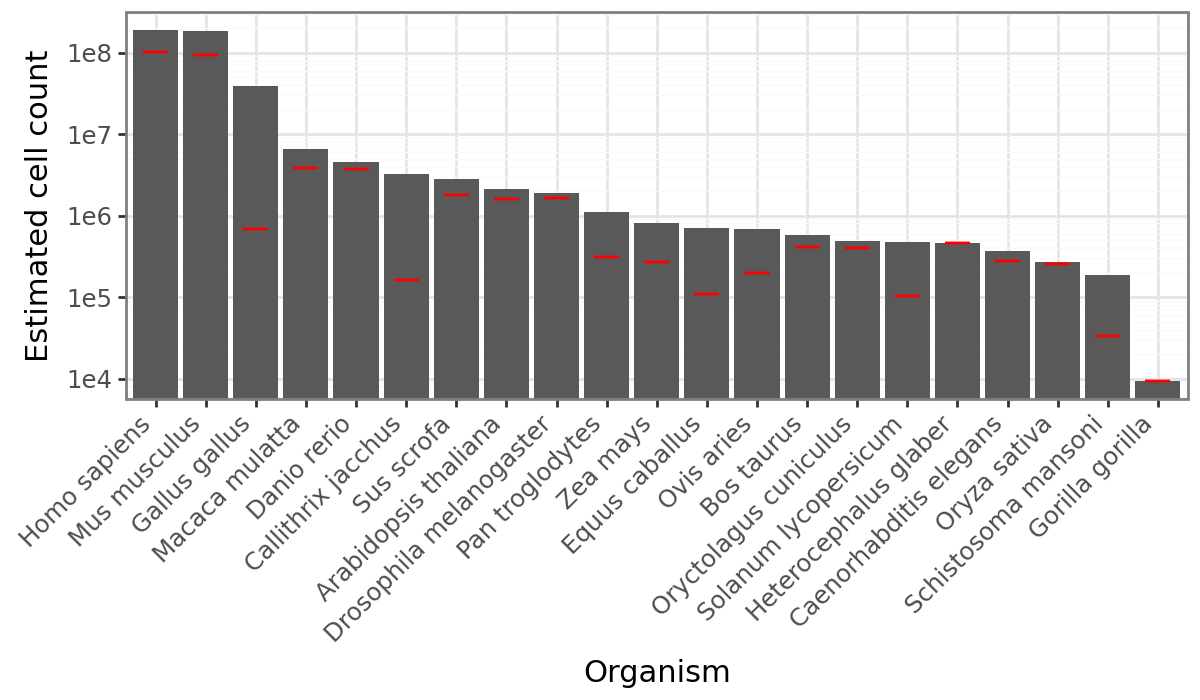

In [70]:
# plot cells per organism
## order by total estimated cells
df_org["organism"] = pd.Categorical(
    df_org["organism"], 
    categories=df_org.groupby(["organism"]).sum().sort_values(by="total_estimated_cells", ascending=False).index
)

# plot
p = (
    pn.ggplot(df_org, pn.aes(x="organism", y="total_estimated_cells")) +
    pn.geom_col() +
    pn.geom_errorbar(pn.aes(ymin="total_processed_cells", ymax="total_processed_cells"), width=0.5, color="red") +
    pn.scale_y_log10() +
    pn.labs(x="Organism", y="Estimated cell count") +
    pn.theme(
        axis_text_x=pn.element_text(angle=45, hjust=1),
        figure_size=(6, 3.5)
    )
)
p

# Session info

In [40]:
!mamba list

# packages in environment at /home/nickyoungblut/miniforge3/envs/SRAgent_nb:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
aiohappyeyeballs          2.6.1                    pypi_0    pypi
aiohttp                   3.11.14                  pypi_0    pypi
aiosignal                 1.3.2                    pypi_0    pypi
annotated-types           0.7.0                    pypi_0    pypi
anyio                     4.9.0                    pypi_0    pypi
appdirs                   1.4.4                    pypi_0    pypi
asgiref                   3.8.1                    pypi_0    pypi
asttokens                 3.0.0              pyhd8ed1ab_1    conda-forge
attrs                     25.3.0                   pypi_0    pypi
backoff                   2.2.1                    pypi_0    pypi
bcrypt                    4.3.0          